# Analyze generated smiles
生成したリガンドを分析するノートブック

In [3]:
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from rdkit import Chem

In [6]:
with open('../config/filepath.yml') as file:
    path_config = yaml.safe_load(file)

with open('../config/model.yml') as file:
    model_config = yaml.safe_load(file)

with open('../config/data.yml') as file:
    data_config = yaml.safe_load(file)

dude_dir = os.path.join('..', path_config['data']['DUD-E'])
alphafold_dir = os.path.join('..', path_config['data']['alphafold'])
smiles_dir = os.path.join('..', path_config['data']['smiles'])
output_dir = os.path.join('..', path_config['data']['plots'])
hist_dir = os.path.join('..', path_config['data']['hist'])
eval_dir = os.path.join('..', path_config['data']['eval'], 'decoder_only')
preprocessed_dir = os.path.join('..', path_config['data']['preprocessed'])
sample_dir = os.path.join('..', path_config['data']['samples'])
model_dir = os.path.join('..', path_config['data']['docking'])

ds_reg_output_dir = os.path.join(output_dir, 'ds_regression')


In [10]:
def filter_valid_smiles(input_df, smiles_column="Generated_SMILES"):
    """
    Filters valid SMILES from a CSV file and calculates the valid SMILES ratio.

    Args:
        input_csv (str): Path to the input CSV file.
        smiles_column (str): Column name containing SMILES strings in the input CSV.

    Returns:
        float: The ratio of valid SMILES.
    """

    # Check if the SMILES column exists
    if smiles_column not in input_df.columns:
        raise ValueError(f"Column '{smiles_column}' not found in the input CSV.")

    # Check validity of SMILES
    input_df['is_valid'] = input_df[smiles_column].apply(lambda x: Chem.MolFromSmiles(x) is not None)

    # Calculate the valid SMILES ratio
    valid_ratio = input_df['is_valid'].mean()

    # Filter only valid SMILES
    valid_data = input_df[input_df['is_valid']].drop(columns=['is_valid'])

    return valid_ratio, valid_data

In [21]:
def plot_docking_scores_with_seed(data, title_filter, 
                                  actual_score_column='r_i_docking_score', 
                                  seed_score=None, 
                                  seed_predicted_score=None,
                                  title_column='title'):
    """
    Filters docking scores for a specific title filter, selects the best (lowest) score for each title,
    plots a boxplot for the actual scores, and overlays the seed compound docking score as a point.

    Args:
        data (DataFrame): The input dataset containing docking scores.
        title_filter (str): The string to filter the titles by.
        actual_score_column (str): The column containing actual docking scores. Defaults to 'r_i_docking_score'.
        seed_score (float or None): The docking score of the seed compound to overlay on the boxplot. If None, no point is overlaid.
        title_column (str): The column containing titles. Defaults to 'title'.

    Returns:
        int: The number of data points used for the boxplot.
    """
    import matplotlib.pyplot as plt

    # Filter rows where the title contains the specified filter string
    filtered_data = data[data[title_column].str.contains(title_filter, na=False)]

    # Retain only the best (lowest) docking score for each unique title
    best_scores = filtered_data.loc[
        filtered_data.groupby(title_column)[actual_score_column].idxmin()
    ]

    # Plot the boxplot for the extracted docking scores
    plt.figure(figsize=(8, 6))
    plt.boxplot(best_scores[actual_score_column], vert=True, patch_artist=True)
    plt.title(f'Generated Ligand Docking Scores for "{title_filter}"')
    plt.ylabel(f'Docking Score ({actual_score_column})')
    plt.xticks([1], [title_filter])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Overlay the seed compound docking score if provided
    if seed_score is not None:
        plt.scatter([1], [seed_score], color='red', label='Seed Compound Score', zorder=5)
        plt.legend()
    
    if seed_predicted_score is not None:
        plt.scatter([1], [seed_predicted_score], color='green', label='Predicted Seed Compound Score', zorder=5)
        plt.legend()

    plt.show()

    # Return the number of data points used for the boxplot
    return best_scores.shape[0]

## DRD3 local model
drd3 のデータセットで学習し、ドッキングスコアの良いもの10個をシード化合物として生成した smiles

In [8]:
drd3_model_timestamp = '2025-01-10_20-12-20'
drd3_best_docking = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'best_docking.csv'))

  SEED_Ligand_ID                                   Generated_SMILES
0   ZINC20605418  CC[C@H](C)[NH+](C)CCNC(=O)c1ccc(-c2c(C)oc3c2CC...
1   ZINC20605418  C[NH+](CCOc1ccc(Br)cc1)CC[NH+]1CCC(O)(c2ccccc2...
2   ZINC20605418                               Nc1nccc2c1sc1ccccc12
3   ZINC20605418                     C[NH+](CCc1ccccc1)Cc1cc(Br)cs1
4   ZINC20605418  CC[C@@H](C)NC(=O)/C(C#N)=C1\S[C@@H]2N=NC(SCc3n...


In [13]:
bd_valid_ratio, bd_valid_data = filter_valid_smiles(drd3_best_docking)
print(f"Valid SMILES ratio: {bd_valid_ratio*100:.2f}")
print(f"Number of valid SMILES: {len(bd_valid_data)}")

Valid SMILES ratio: 86.30
Number of valid SMILES: 863


[01:33:17] Explicit valence for atom # 28 N, 4, is greater than permitted
[01:33:17] SMILES Parse Error: extra close parentheses while parsing: O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21
[01:33:17] SMILES Parse Error: check for mistakes around position 43:
[01:33:17] 3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21
[01:33:17] ~~~~~~~~~~~~~~~~~~~~^
[01:33:17] SMILES Parse Error: Failed parsing SMILES 'O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21' for input: 'O=S1(=O)[C@H]2CC[C@@H]3CC(CCC4=CCC=CCC4)O3)N=N[C@@H]21'
[01:33:17] Explicit valence for atom # 7 N, 6, is greater than permitted
[01:33:17] SMILES Parse Error: unclosed ring for input: 'Cc1cc2c(N3CCO[C@@H]4C3)c(C(=O)Nc3ccc(F)cc3C(F)(F)F)ccc2o1'
[01:33:17] SMILES Parse Error: unclosed ring for input: 'C[C@H]1[C@H]2[C@@H](c3ccccc3)Nc3cc(C[NH2+]C[C@@H](C)O)ccc2N(CC(=O)N(C)C)C1=O'
[01:33:17] SMILES Parse Error: unclosed ring for input: 'Cc1ccc2c(C)c(C(=O)NC3CC4CCC(CC(=O)NC5CCCCC5)[C@H](C)C3)sc2n1'
[01:33:17] Explicit valence for a

ランダムにシードを選んで生成したsmiles

In [15]:
drd3_random = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'random.csv'))
random_valid_ratio, random_valid_data = filter_valid_smiles(drd3_random)
print(f"Valid SMILES ratio: {random_valid_ratio*100:.2f}")
print(f"Number of valid SMILES: {len(random_valid_data)}")

Valid SMILES ratio: 83.30
Number of valid SMILES: 833


[02:21:34] SMILES Parse Error: syntax error while parsing: COc1cc(NC(=O)CSc2nc3ccccc3[nH2)ccc1=[NH+]
[02:21:34] SMILES Parse Error: check for mistakes around position 31:
[02:21:34] =O)CSc2nc3ccccc3[nH2)ccc1=[NH+]
[02:21:34] ~~~~~~~~~~~~~~~~~~~~^
[02:21:34] SMILES Parse Error: Failed parsing SMILES 'COc1cc(NC(=O)CSc2nc3ccccc3[nH2)ccc1=[NH+]' for input: 'COc1cc(NC(=O)CSc2nc3ccccc3[nH2)ccc1=[NH+]'
[02:21:34] SMILES Parse Error: syntax error while parsing: Cc1ccc2c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C
[02:21:34] SMILES Parse Error: check for mistakes around position 28:
[02:21:34] c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C
[02:21:34] ~~~~~~~~~~~~~~~~~~~~^
[02:21:34] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc2c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C' for input: 'Cc1ccc2c(=O)c(C[NH+](C)[C@HH]3CCC(=O)N3)coc2c1C'
[02:21:34] SMILES Parse Error: unclosed ring for input: 'C=CCN(CC=C)S(=O)(=O)c1ccc2c(c1)NC(=O)[C@@H](C)[NH2+]C1=CC2=c3cccc(O)c3N=[NH+]C2=S'
[02:21:34] Can't kekulize mol.  Unk

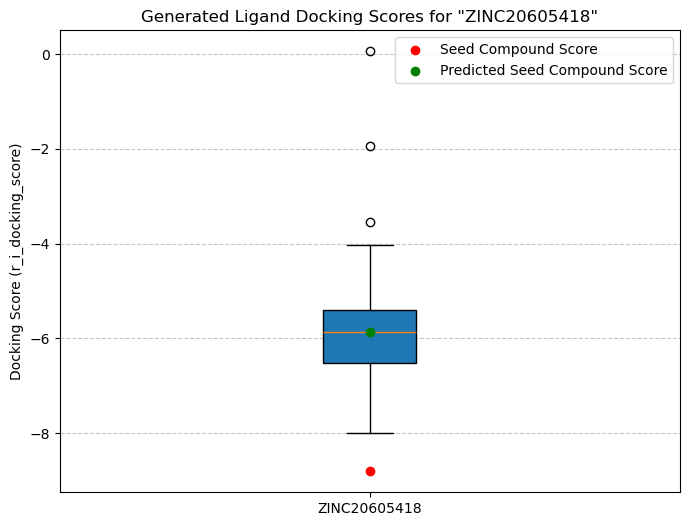

85

In [22]:
best_score_docking = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'best_score_docking.csv'))

seed_score = -8.806
seed_predicted_score = -5.860
plot_docking_scores_with_seed(best_score_docking, 'ZINC20605418', seed_score=seed_score, seed_predicted_score=seed_predicted_score)

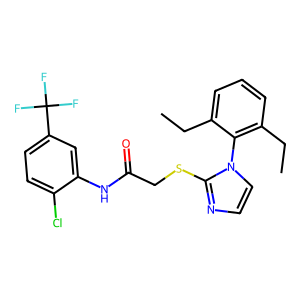

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = "CCc1cccc(CC)c1-n1ccnc1SCC(=O)Nc1cc(C(F)(F)F)ccc1Cl"
molecule = Chem.MolFromSmiles(smiles)
Draw.MolToImage(molecule)

ドッキングスコア予測のよいものをシードにして生成したSMILES

In [16]:
drd3_accurate = pd.read_csv(os.path.join(eval_dir, drd3_model_timestamp, 'accurate.csv'))
accurate_valid_ratio, accurate_valid_data = filter_valid_smiles(drd3_accurate)
print(f"Valid SMILES ratio: {accurate_valid_ratio*100:.2f}")
print(f"Number of valid SMILES: {len(accurate_valid_data)}")

Valid SMILES ratio: 84.90
Number of valid SMILES: 849


[02:22:54] SMILES Parse Error: extra close parentheses while parsing: FC(F)(F)Cc1nc2sc3c(n2c1CSCCO)c(=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1
[02:22:54] SMILES Parse Error: check for mistakes around position 51:
[02:22:54] (=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1
[02:22:54] ~~~~~~~~~~~~~~~~~~~~^
[02:22:54] SMILES Parse Error: Failed parsing SMILES 'FC(F)(F)Cc1nc2sc3c(n2c1CSCCO)c(=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1' for input: 'FC(F)(F)Cc1nc2sc3c(n2c1CSCCO)c(=O)n(CCCl)c3ccccc31)C[C@@H]2c1ccccc1'
[02:22:54] SMILES Parse Error: extra open parentheses while parsing: O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)c1Cl
[02:22:54] SMILES Parse Error: check for mistakes around position 4:
[02:22:54] O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)
[02:22:54] ~~~^
[02:22:54] SMILES Parse Error: Failed parsing SMILES 'O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)c1Cl' for input: 'O=C(C[NH+]1CCn2cccc2[C@@H]1c1ccc(Cl)c(Cl)c1Cl'
[02:22:54] Can't kekulize mol.  Unkekulized atoms: 2 3 4 11 12 13 14 17 18
[02:22:54] Explici